# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model.

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$).

In this part we will use the **_display_** function to visualize the images.

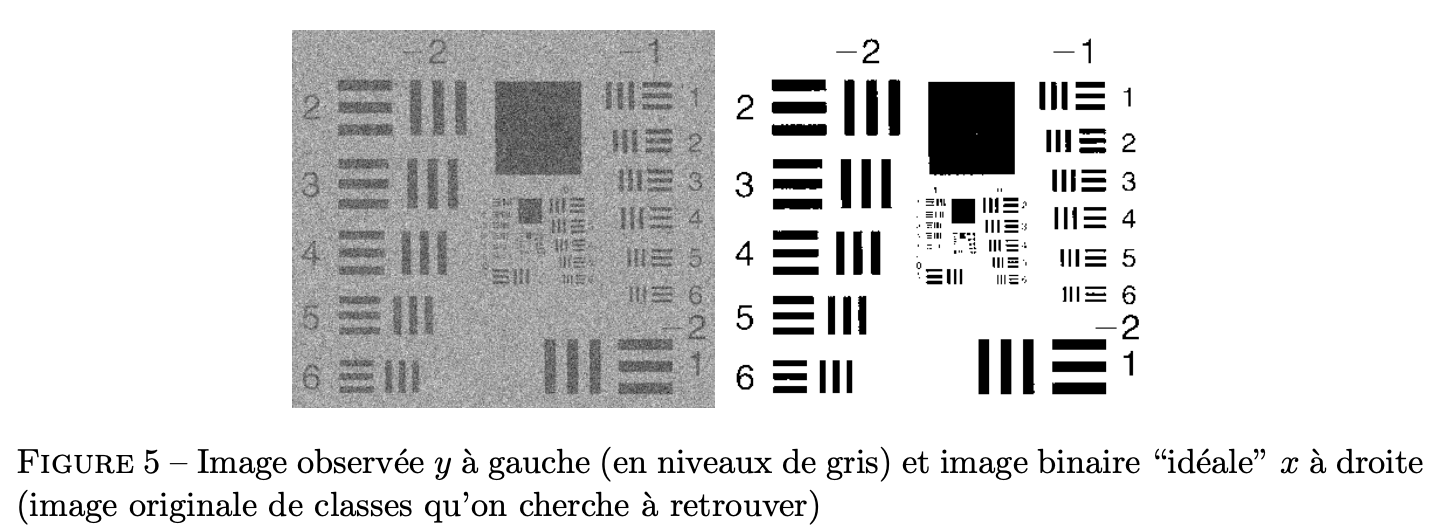

In [3]:
import math
import random
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
import imageio
from scipy import ndimage as ndi
from skimage import io

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[0, im.shape[0]], x_range=[0, im.shape[1]])
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=0, dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

The scikit-image library allows to read images from a URL. The "display" function allows to access directly to the grey levels and to the pixels positions by using the mouse.

In [5]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")

affiche(im_obs)

In [6]:
im_ori=io.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')

affiche(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model.
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$

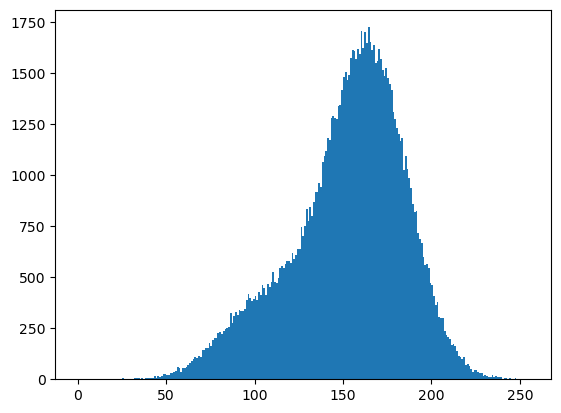

In [7]:
#study of the global distribution of the image
#display of the histogram of the image
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=np.max(im_obs))
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image).

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

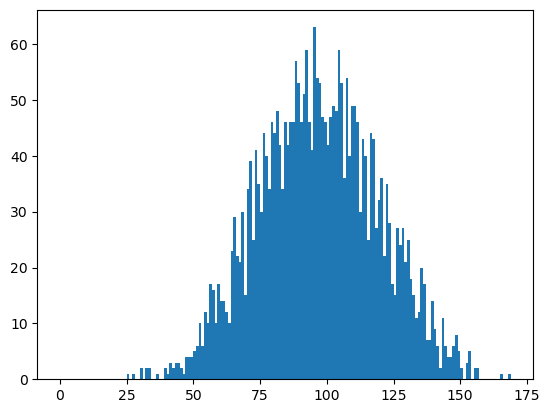

In [8]:
#select a small window in a dark region of the image (class 0)
#be careful, the ordinates correspond to the rows and the abscissas to the columns
crop_classe0=im_obs[45:105,180:230]
#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(),range=[0,np.max(crop_classe0)],bins=np.max(crop_classe0))
plt.show()

In [9]:
#calculate its mean and variance
#
# By default, np.mean, np.zzz takes the two axes of the image.
# You have to force the option if you want to do the average in row or in column
# use np.mean and np.var
m0=np.mean(crop_classe0)
var0=np.var(crop_classe0)

print(m0)
print(var0)

96.43833333333333
497.8375305555556


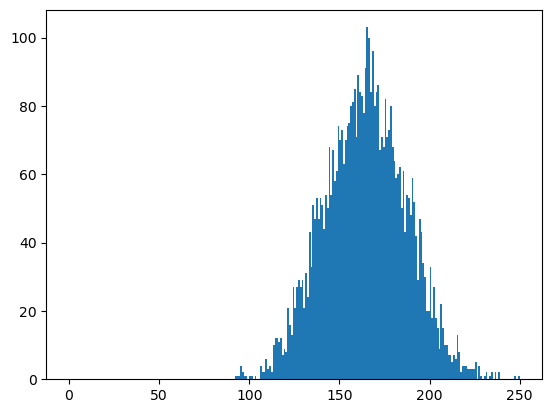

In [10]:
#select a small window in a dark region of the image (class 1)
crop_classe1=im_obs[230:300,130:200]
#plot its histogram
plt.figure()
plt.hist(crop_classe1.ravel(),range=[0,np.max(crop_classe1)],bins=np.max(crop_classe1))
plt.show()

In [11]:
#calculate its mean and variance
m1=np.mean(crop_classe1)
var1=np.var(crop_classe1)

print(m1)
print(var1)

163.87755102040816
512.7315368596419


### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated.

### A1
The obtained histograms has the same allure as the normal distribution. So, in order to characterize them we computed the respective mean and variance of each normal distribution

### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions.

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2
If we classify a pixel based only on the grey level, we can write

* $P(Y_s|0)= \mathcal{N}(96,500)$
* $P(Y_s|1)= \mathcal{N}(164,500)$

<br>
We cab write the gaussien law : $P(Y_s|X_s)=\frac{1}{\sqrt{2\pi}\sigma_{x_s}}\exp^{\frac{-(y_s-\mu_{x_s})^2}{2\sigma_{x_s}^2}}$

<br>
Then To classify a pixel in  **Class 0**, we need :

<br>

$$P(Y_s| 0)>P(Y_s|1)$$

<br>

$$\frac{1}{\sqrt{2\pi}\sigma_{0}}\exp^{\frac{-(y_s-\mu_{0})^2}{2\sigma_{0}^2}}>\frac{1}{\sqrt{2\pi}\sigma_{1}}\exp^{\frac{-(y_s-\mu_{1})^2}{2\sigma_{1}^2}}$$

<br>
Since we assumed that these distributaions have the same variance :

$$(y_s-\mu_0)^2 < (y_s-\mu_1)^2$$

In the end we get the threshold value :
$$y_s < \frac{\mu_0+\mu_1}{2}$$


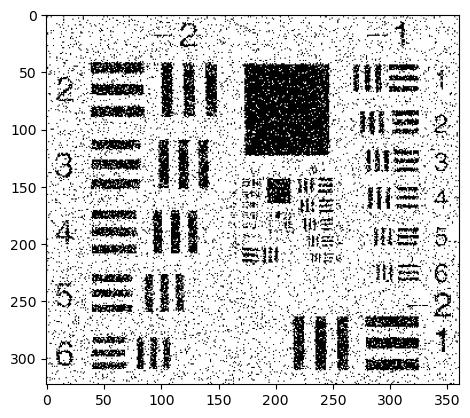

In [12]:
# Set the threshold for classification in the ML sense and display the image
threshold=(m0+m1)/2
im_bin=(im_obs.copy()) >= threshold
plt.imshow(im_bin,cmap='gray')

###Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$

###A3
$$
U(x|y) = \sum _{s \in S} -ln(P(Y_s|X_s))
$$
$$
=\sum_{s\in S} [ln(\sqrt{2\pi } \sigma_{xs})+\frac{(y_s-\mu_{xs})^2}{2\sigma_{xs}^2}]
$$
Since
$$
P(Y_s|X_s) = \frac{1}{\sqrt{2\pi} \sigma_{XS}} e^{\frac{-(y_s-\mu_{xs})^2}{2\sigma_{xs}^2}}
$$

## 2 Ising model for regularisation and energies
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise.
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously.

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4
- _global energy_: $$
U(x|y)=\sum_{s\in S} [ln(\sqrt{2\pi } \sigma_{xs})+\frac{(y_s-\mu_{xs})^2}{2\sigma_{xs}^2}] + \beta \sum _{\{s,t\}} \Delta(x_s,x_t)
$$
we can further simplify the expression by removing the constants as mentioned in the Tip :
$$
U(x|y)=\sum_{s\in S} [\frac{(y_s-\mu_{xs})^2}{2\sigma_{xs}^2}] + \beta \sum _{\{s,t\}} \Delta(x_s,x_t)
$$
- _local conditional energy_:$$
U(x_s |y_{s},x_t \in v_s)=  \frac{(y_s-\mu_{xs})^2}{2\sigma_{xs}^2} + \beta \sum _{\{t\in v_s\}} \Delta(x_s,x_t)
$$

### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

In [13]:
print((105-m0)**2/(2*var0) ,(105-m1)**2/(2*var1))

0.07362054044952228 3.3804883891018824


### A5
$$U(0|y_s =105 ,  0, 1, 1, 1) = \frac{(105-m_0)^2}{2\sigma_0^2} + 3\beta \approx 0.0736 +3 \beta $$
$$U(1|y_s =105 ,  0, 1, 1, 1) = \frac{(105-m_1)^2}{2\sigma_1^2} + \beta \approx 3.3805 + \beta $$

### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?

### A6
this depends on the value of beta. if $0.0736 + 3\beta < 3.3805 + \beta \Leftrightarrow  \beta < \frac{3.3805-0.0736}{2} = 3.3437$ then we will choose the value 0 ,here $U(0|y,v_s)< U(1|y,v_s)$ and in other case $beta > 3.3437 $ we choose the value 1

### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7
When we set beta =0, we consider thar the expression of the energy has only the data attachement term  (Q3) and we are back to the case where the energy only comes from the pixels that the interactions between the pixel and the neighbours are no longer taken into consideration. So the solution that minimizes the global energy is the same as the previous approach (A2) : we consider the same thershold and we get the same solution

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8
when beta is approaching great values i.e tends to infinty we will emphasize more on the regularization term in the energy expression and the data attachement term will be neglected. As consequence, minimizing U will be the same as finding the image that minimizes the ising model. in our case the ising model penelizes the differences in pixels so the images that minizes the global energy will be the images with same value in all sites ( all white or all black ) no matter what data we get.

### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model.

### A9
In the first part we were only focusing on the data attachement term in the energy. By intreducing the regularization term described by the markovian model we took into consideration a certain structure that the data has (our prior knowledge).
when beta increases we will tend to emphases more on the regularisation term. In this case we are facing a compromize between data attachement term which describes the relation between our data and the target. And the regularisation term which translates our prior knowledge on the data. the more we increase beta the more we will take into account the importance of the regularization compared to the ressemblence to the data we have.

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  

Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image).

In [14]:
def iter_icm(im_bin,im_toclass,beta_reg,m0,m1):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            # do not change these indices they allow access to neighboring pixels
            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            U0_att = (im_toclass[i,j] - m0)**2 /(2*500)
            U0_reg = (int(im_bin[i,j1])+int(im_bin[i,j2])+int(im_bin[i1,j])+int(im_bin[i2,j]))*beta_reg

            U0=U0_att +  U0_reg

            # energy computation if the pixel is put in class 1
            U1_att = (im_toclass[i,j] - m1)**2 /(2*500)
            U1_reg = beta_reg *(4-(im_bin[i,j1]+im_bin[i,j2]+im_bin[i1,j]+im_bin[i2,j]))
            U1=U1_att +  U1_reg
            #if((im_bin[i1,j1]+im_bin[i1,j2]+im_bin[i2,j1]+im_bin[i2,j2]) != True and (im_bin[i1,j1]+im_bin[i1,j2]+im_bin[i2,j1]+im_bin[i2,j2]) != False):
            #print(i1,i2,j1,j2,(int(im_bin[i1,j1])+int(im_bin[i1,j2])+int(im_bin[i2,j1])+int(im_bin[i2,j2])),U0_att,U0_reg,U0,U1_att,U1_reg,U1)
            if (U0>U1):
                im_bin[i,j]=1
            else :
                im_bin[i,j]=0

    return im_bin


### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

### A10
A good initialization will be the threshholded image obtained previously. In fact, this choice can be justified as follows:
We know that ICM algorithm gives local minima. So we want to be as close as possible to the minima that we want to reach (in our case the global minima ). And since we already have a very close solution (the thresholeded one ) we can just start from that image and we will probably reach the global minima.

Implement the ICM and study the influence of $\beta$.

A good value of regularization term will be one above the value 3.3437 that we obtained in the question 8. In fact, for the example that we obtained we noitice that since the majority of neighbours are of class 1 ,and our target image tends to have same class of the neighbourhood . So we want the resulting value to be of the same class so 1. As a result we will start out by beta =4

In [15]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg= 4
#initialise the binary image of the classes
im_bin = ((im_obs.copy()) >= threshold )*1

affiche(im_bin)
# program a loop in which we call iter_icm
# and display the class image as iterations are performed
for n in range(10):
    im_bin=iter_icm(im_bin,im_obs,beta_reg,m0,m1)
affiche(im_bin)

### Q12
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.

###A12
we get a good solution with beta = 4.In this solution we noitice that we have better shapes (the big black squares doesn't contain white points) and it is more clear than the intial method

You can compare your result with the original image to find the right regularisation parameter.

In [17]:
betas = np.linspace(0,10,20)
images=[]
diffs =[]
for beta_reg in betas : 
    im_bin = ((im_obs.copy()) >= threshold )*1
    for n in range(10):
        im_bin=iter_icm(im_bin,im_obs,beta_reg,m0,m1)
    images.append(im_bin)
    diffs.append(abs(im_bin-im_ori).sum())



In [23]:
affiche (images[10])

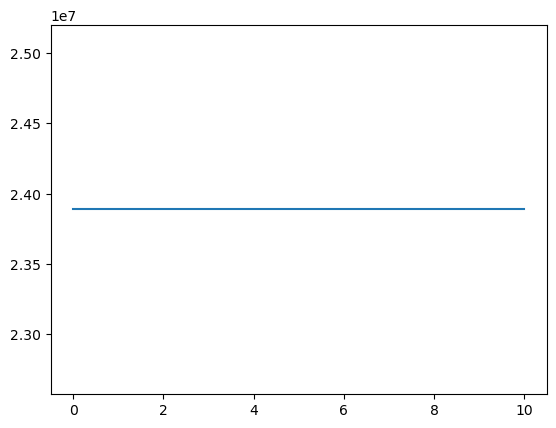

In [18]:
plt.plot(betas,diffs)

In [14]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg= 
#initialise the binary image of the classes
im_bin = ((im_obs.copy()) >= threshold )*1

affiche(im_bin)
# program a loop in which we call iter_icm
# and display the class image as iterations are performed
for n in range(10):
    im_bin=iter_icm(im_bin,im_obs,beta_reg,m0,m1)
affiche(im_bin)
#use np.abs to calculate the absolute value of the difference
# between the original binary image and the ICM result
# note: im_bin is coded between 0 and 1 and im_ori between 0 and 255
ima_diff= np.abs( 255*im_bin - im_ori)
affiche(ima_diff )

here we noitice that the mojirity of the dfference image is black which indicates that we have a close solution

### Q13
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

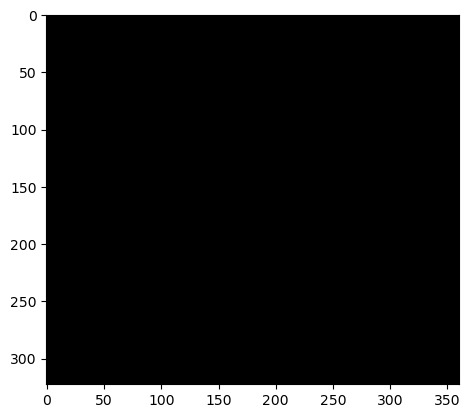

In [15]:
#initialise the binary image of the classes with full zeros
im_bin1 = np.zeros_like(im_obs)
plt.imshow(im_bin1,cmap="gray")
plt.show()
# program a loop in which we call iter_icm
# and display the class image as iterations are performed
for n in range(10):
    im_bin1=iter_icm(im_bin1,im_obs,beta_reg,m0,m1)
affiche(im_bin1)

In [16]:
#initialise the binary image of the classes with random values
im_bin2 = 2-np.ceil(2*np.random.rand(*im_obs.shape))
affiche(im_bin2)
# program a loop in which we call iter_icm
# and display the class image as iterations are performed
for n in range(10):
    im_bin2=iter_icm(im_bin2,im_obs,beta_reg,m0,m1)
affiche(im_bin2)

###A13
For the first case (all zeros image) we got a solution that is mostly black. In fact, ICM gave us a local minima. This proves that even with a good choice of parmaeters we can get stuck in a local minima that is far of our target. In the other case we got a solution somewhat acceptable but it still lacks some of the structures and changes with the intialization. However we can get consistent results when we use the intialization that we got with thresholding

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [17]:
def echan_r(im_bin,im_toclass,beta_reg,m0,m1,T):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):

            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            U0_att = (im_toclass[i,j] - m0)**2 /(2*var0)
            U0_reg = (int(im_bin[i,j1])+int(im_bin[i,j2])+int(im_bin[i1,j])+int(im_bin[i2,j]))*beta_reg
            U0=U0_att +  U0_reg

            p0=math.exp(-U0/T);

            U1_att = (im_toclass[i,j] - m1)**2 /(2*var1)
            U1_reg = (4-(int(im_bin[i,j1])+int(im_bin[i,j2])+int(im_bin[i1,j])+int(im_bin[i2,j])))*beta_reg
            U1=U1_att +  U1_reg

            p1=math.exp(-U1/T);

            if (p0+p1!=0.):
                if(random.uniform(0,1)<p0/(p0+p1)):
                    im_bin[i,j]=0
                else :
                    im_bin[i,j]=1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough.

In [18]:
print("approximative number of iterations to reach 0.01 starting from 1000 is :", np.log(0.001/180)/np.log(0.98))

approximative number of iterations to reach 0.01 starting from 1000 is : 598.964878305137


In [19]:
# Program the simulated annealing
#temperature initialization
# initial temperature
T=1000
alpha = 0.8
#initialization of the binary image
im_bin =2-np.ceil(2*np.random.rand(*im_obs.shape))
affiche(im_bin)

# make a loop by calling the function that does a Gibbs sampling at T
for n in range(600):
    #print(n)
    im_bin=echan_r(im_bin,im_obs,beta_reg,m0,m1,T)
    T=T*alpha
affiche (im_bin)


###Q14
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

###A14
Yes, the results matches those seen in the course :
The results obtained by the simulated annealing are better than those obtained in ICM and does not depend on the intialization (allways converges to global minimum). In fact, in my implementation I started from a totally random image and still got a good approximation of the target. However this method takes much more time to converge and the pertinance of the results depends on how much we respect the decrease in T (should be slow ) and the starting T value( T0).
But the ICM are still applicable and gives acceptable results within a very short time with much fiewer computation.